In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')
from plotly.subplots import make_subplots


/var/folders/xn/g_4w7kgs45j894yq9pd26gv40000gn/T/ipykernel_72805/1454016396.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [9]:
def load_datamap_stats(base_path):
    '''
    Returns datamap stats recorded during training split by epochs

            Parameters:
                    base_path (str): Path to model metadata

            Returns:
                    df (DataFrame): Pandas dataframe with datamap stats: 
                                    confidence, variability and correctness
    '''
    # load logged stats from training 
    with open(base_path + 'datamaps_stats.json') as fp:
        datamap_stats_raw = json.load(fp)

    result = collections.defaultdict(list)
    for stat in datamap_stats_raw:
        result[stat['Epoch']].append(stat)
    datamap_stats = list(result.values())
    #datamap_stats = list(datamap_stats.values())

    return datamap_stats

def calc_confidence(df_probabilities):
    '''Calculates confidence by taking the mean for each instance probability at ground truth over all epochs'''
    x = np.array(df_probabilities['Probabilities'].tolist())
    confidence = np.mean(x.astype(float), axis=1)
    return confidence

def calc_variance(df_probabilities):
    '''Calculates variance by taking the standard deviation for each instance probability at ground truth over all epochs'''
    x = np.array(df_probabilities['Probabilities'].tolist())
    variance = np.std(x.astype(float), axis=1)
    return variance

def calc_correctness(df_correct_preds):
    '''Calculates correctness by measuring the number of times prediction == target'''
    x = np.array(df_correct_preds['Corrects'].tolist())
    boolean_array = (x=='True')
    sums = np.sum(boolean_array, axis=1)
    correctness = sums/len(df_correct_preds.loc[0]['Corrects'])
    return correctness


def remove_duplicates(id_probs, probs_corrects, col_name):
    predictions = pd.DataFrame(list(zip(id_probs.keys(), probs_corrects)),
    columns =['Question ID', col_name])
    predictions_duplicate = predictions[col_name].values
    predictions_remove_duplications = []
    for pred in predictions_duplicate:
        update = list(set(pred))
        if col_name != 'Predictions':
            if len(update) != 1:
                print(col_name)
                print(update)
                print("INVALID")
        predictions_remove_duplications.append(list(set(pred)))
    predictions[col_name] = predictions_remove_duplications
    return predictions

def calculate_datamap_metrics(datamap_stats, correctness_check=False):
    '''
    Returns dataframe with confidence, correctness and variability for datamap plotting

            Parameters:
                    datamap_stats (list): List of instance metadata for datamap 
                                          generation bucketed by epoch

            Returns:
                    df (DataFrame): Pandas dataframe with datamap metrics and question ids
    '''
    coco_train = COCO('coco/annotations/instances_train2014.json')
    coco_val = COCO('coco/annotations/instances_val2014.json')
    ids_probs = {}
    for example in datamap_stats[0]:
        ids_probs[example['Question ID']]=([],[],[],[],[],[]) # probabilities, corrects, question, target, prediction, image_id 

    for epoch_instances in datamap_stats:
        for example in epoch_instances:
            if example['Target'] == 'geese' and example['Prediction'] == 'goose': # special case in animal split
                correct = True
            elif example['Prediction'][-1] == 's' and example['Prediction'][-1] == example['Target']: # account for plurals in animal split
                correct = True
            elif example['Target'] == example['Prediction']:
                correct = True
            else:
                correct = False
            ids_probs[example['Question ID']][0].append(example['GT Probability'])
            ids_probs[example['Question ID']][1].append(correct)
            ids_probs[example['Question ID']][2].append(example['Question'])
            ids_probs[example['Question ID']][3].append(example['Target'])
            ids_probs[example['Question ID']][4].append(example['Prediction'])
            ids_probs[example['Question ID']][5].append(example['Image ID'])

    probs_corrects = np.array(list(ids_probs.values()))
    probabilities = pd.DataFrame(list(zip(ids_probs.keys(), probs_corrects[:, 0, :])),
                columns =['Question ID', 'Probabilities'])

    corrects = pd.DataFrame(list(zip(ids_probs.keys(), probs_corrects[:, 1, :])),
                columns =['Question ID', 'Corrects'])

    predictions = remove_duplicates(ids_probs, probs_corrects[:, 4, :], 'Predictions')
    questions = remove_duplicates(ids_probs, np.squeeze(probs_corrects[:, 2, :]), 'Question')
    targets = remove_duplicates(ids_probs, np.squeeze(probs_corrects[:, 3, :]), 'Target')
    image_ids = remove_duplicates(ids_probs, np.squeeze(probs_corrects[:, 5, :]), 'Image ID')
    ids_list = image_ids['Image ID']
    img_urls = []
    for img in ids_list:
        id_str = str(img[0])
        if 'val' in id_str:
            loaded_img = coco_val.loadImgs([int(id_str[-6:])])
        else:
            loaded_img = coco_train.loadImgs([int(id_str[-6:])])
        
        assert len(loaded_img) == 1
        img_urls.append(loaded_img[0]['coco_url'])

    confidence_score = calc_confidence(probabilities)
    variance_score = calc_variance(probabilities)
    correctness_score = calc_correctness(corrects)

    d= {"confidence": np.squeeze(confidence_score), "variability": np.squeeze(variance_score), "correctness":correctness_score, "question_id":probabilities['Question ID'],
        "Predictions": predictions['Predictions'], "Question":questions['Question'], "Target":targets['Target'], "Image ID":ids_list, "Image URL":img_urls}
    df= pd.DataFrame(d)

    if correctness_check == True:
        low_correctness_high_confidence = df.loc[(df['correctness'] < 0.4) & (df['confidence'] > 0.8)]

        ids = low_correctness_high_confidence.index

        for id in ids:  
            x = probabilities.loc[id]
            y = corrects.loc[id]

            d_exp = {'probabilities':x, 'correctness': y}
            df_exp = pd.DataFrame(data=d)
            print(df_exp)

    return df

def plot_trainval_acc(base_path):
    '''
    Plots train/val accuracy scores 

            Parameters:
                    base_path (str): Path to model metadata

    '''
    with open(base_path + 'log.log') as fp:
        acc = fp.readlines()
    train_scores = []
    valid_scores = []
    for i in acc:
        if 'Train' in i:
            train_scores.append(float(i[-7:].strip()))
        elif 'Valid' in i:
            valid_scores.append(float(i[-7:].strip()))

    xs_valid = [i for i in range(len(valid_scores))]
    xs_train = [i for i in range(len(train_scores))]
    plt.plot(xs_valid, valid_scores, label="Validation")
    #plt.title("Validation")
    plt.savefig(base_path+'/training.png')

    plt.plot(xs_train, train_scores, label="Training")
    #plt.title("Training")
    plt.savefig(base_path+'/validation.png')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Correct Preds")

def scatter_it(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
    pal.reverse()

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')


    # fig = px.scatter(dataframe, x=main_metric,
    #                        y=other_metric, 
    #                        color=hue,
    #                        symbol=style,
    #                        size_max=30)
    # fig.show()

    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()
    #filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    #fig.savefig(filename, dpi=300)

def datamap_outliers(df, datamap_stats, confidence_threshold, variability_threshold, region):
    '''
    Extracts instances in datamap regions: hard, ambiguous, and easy

            Parameters:
                    df (DataFrame): Pandas dataframe with datamap metrics and question ids

                    datamap_stats (list): List of instance metadata for datamap 
                                          generation bucketed by epoch

                    confidence_threshold (float): threshold at which to segment the datamap (y axis) 

                    variability_threshold (float): threshold at which to segment the datamap (x axis) 

                    region (str): 'easy', 'hard', 'ambiguous', region of datamap 

            Returns:
                    outliers_metadata (list): List of metadata for outlier instances

                    img_ids (set): Image ids of outliers for extraction from dataset 
    '''

    if region == 'hard':
        # segment instances thresholded on confidence and variability to separate regions on datamap 
        outliers = df.loc[(df['confidence'] < confidence_threshold) & (df['variability'] < variability_threshold)]
    elif region == 'easy':
        outliers = df.loc[(df['confidence'] > confidence_threshold) & (df['variability'] < variability_threshold)]
    else:
        outliers = df.loc[(df['confidence'] > confidence_threshold) & (df['variability'] > variability_threshold)]
    ques_ids = outliers['question_id']

    outliers_metadata = []
    data_batch = datamap_stats[0]
    for id in ques_ids:
        for j in data_batch:
            if j['Question ID'] == id:
                outliers_metadata.append(j)
    img_ids = []
    for example in outliers_metadata:
        img_ids.append(example['Image ID'])

    img_ids_train = []
    img_ids_val = []

    for i in img_ids:
        if 'val' in i:
            img_ids_val.append(int(i[-6:]))
        else:
            img_ids_train.append(int(i[-6:]))
    return outliers_metadata, set(img_ids_train), set(img_ids_val)


# def generate_datamap_images(df, base_path):
#     image_ids = list(itertools.chain.from_iterable(df['Image ID']))
#     image_ids_val = []
#     image_ids_train = []
#     for id in image_ids:
#         if 'val' in id:
#             image_ids_val.append(int(id[-6:]))
#         else:
#             image_ids_train.append(int(id[-6:]))    
#     dataset_val = foz.load_zoo_dataset(
#                     "coco-2014",
#                     split='validation',
#                     image_ids=image_ids_val,
#                     dataset_dir=base_path+'datamap_imgs'
#                 )
#     dataset_train = foz.load_zoo_dataset(
#                     "coco-2014",
#                     split='train',
#                     image_ids=image_ids_train,
#                     dataset_dir=base_path+'datamap_imgs'
#                 )

In [4]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
    pal.reverse()

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')


    # fig = px.scatter(dataframe, x=main_metric,
    #                        y=other_metric, 
    #                        color=hue,
    #                        symbol=style,
    #                        size_max=30)
    # fig.show()

    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()
    #filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    #fig.savefig(filename, dpi=300)

def datamap_outliers(df, datamap_stats, confidence_threshold, variability_threshold, region):
    '''
    Extracts instances in datamap regions: hard, ambiguous, and easy

            Parameters:
                    df (DataFrame): Pandas dataframe with datamap metrics and question ids

                    datamap_stats (list): List of instance metadata for datamap 
                                          generation bucketed by epoch

                    confidence_threshold (float): threshold at which to segment the datamap (y axis) 

                    variability_threshold (float): threshold at which to segment the datamap (x axis) 

                    region (str): 'easy', 'hard', 'ambiguous', region of datamap 

            Returns:
                    outliers_metadata (list): List of metadata for outlier instances

                    img_ids (set): Image ids of outliers for extraction from dataset 
    '''

    if region == 'hard':
        # segment instances thresholded on confidence and variability to separate regions on datamap 
        outliers = df.loc[(df['confidence'] < confidence_threshold) & (df['variability'] < variability_threshold)]
    elif region == 'easy':
        outliers = df.loc[(df['confidence'] > confidence_threshold) & (df['variability'] < variability_threshold)]
    else:
        outliers = df.loc[(df['confidence'] > confidence_threshold) & (df['variability'] > variability_threshold)]
    ques_ids = outliers['question_id']

    outliers_metadata = []
    data_batch = datamap_stats[0]
    for id in ques_ids:
        for j in data_batch:
            if j['Question ID'] == id:
                outliers_metadata.append(j)
    img_ids = []
    for example in outliers_metadata:
        img_ids.append(example['Image ID'])

    img_ids_train = []
    img_ids_val = []

    for i in img_ids:
        if 'val' in i:
            img_ids_val.append(int(i[-6:]))
        else:
            img_ids_train.append(int(i[-6:]))
    return outliers_metadata, set(img_ids_train), set(img_ids_val)


In [10]:

def scatter_it_interactive(dataframe, base_path, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):

    # Subsample data to plot, so the plot is not too busy.
    #dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    # coco_train = COCO('coco/annotations/instances_train2014.json')
    # coco_val = COCO('coco/annotations/instances_val2014.json')
    # Normalize correctness to a value between 0 and 1.
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    # if not show_hist:
    #     fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    #     ax0 = axs
    # else:
    #     fig = plt.figure(figsize=(16, 10), )
    #     gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
    #     ax0 = fig.add_subplot(gs[0, :])
    
    
    # ### Make the scatterplot.
    # fig = px.scatter(dataframe, x=main_metric,
    #                        y=other_metric, 
    #                        color=hue,
    #                        symbol=style,
    #                        size_max=30)
    # fig.show()

    fig = go.Figure(data=[
        go.Scatter(
            x=dataframe[main_metric],
            y=dataframe[other_metric],
            mode="markers",
            marker=dict(
                colorscale='viridis',
                color=dataframe[hue],
                colorbar={"title": "Correctness"},
                line={"color": "#444"},
                reversescale=True,
                sizeref=45,
                sizemode="diameter",
                opacity=0.8,
            ),
        )
    ])

    # fig = go.Figure(data=[
    #     px.scatter(dataframe, x=main_metric, y=other_metric, color=hue)
    # ])

    # turn off native plotly.js hover effects - make sure to use
    # hoverinfo="none" rather than "skip" which also halts events.
    fig.update_traces(hoverinfo="none", hovertemplate=None)

    fig.update_layout(
        xaxis=dict(title=main_metric),
        yaxis=dict(title=other_metric),
        plot_bgcolor='rgba(255,255,255,0.1)',
        title = title
    )

    fig2 = make_subplots(rows=1, cols=3, subplot_titles=('Confidence', 'Variability', 'Correctness'))
    fig2.add_trace(go.Histogram(histfunc="count", x=dataframe["confidence"]), row=1, col=1)
    fig2.add_trace(go.Histogram(histfunc="count", x=dataframe["variability"]), row=1, col=2)
    fig2.add_trace(go.Histogram(histfunc="count", x=dataframe["correct."]), row=1, col=3)


    fig2.update_layout(yaxis_title='Density', showlegend=False)



    #app = JupyterDash(__name__)
    app = Dash(__name__)


    app.layout = html.Div([
        html.H1(children=title),
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
        dcc.Graph(id="graph2", figure=fig2),
    ])


    @app.callback(
        Output("graph-tooltip", "show"),
        Output("graph-tooltip", "bbox"),
        Output("graph-tooltip", "children"),
        Input("graph", "hoverData"),
    )

    def display_hover(hoverData):
        if hoverData is None:
            return False, no_update, no_update

        # demo only shows the first point, but other points may also be available
        print(hoverData)
        pt = hoverData["points"][0]
        bbox = pt["bbox"]
        num = pt["pointNumber"]

        df_row = dataframe.iloc[num]
        variability = df_row['variability']
        confidence = df_row['confidence']
        correctness = df_row['correctness']
        predictions = df_row['Predictions']
        question = df_row['Question']
        target = df_row['Target']
        img_src = df_row['Image URL']
        
        #if len(desc) > 300: desc = desc[:100] + '...'
        # image_id = str(df_row['Image ID'][0])
        # if 'val' in image_id:
        #     split = 'validation'
        #     image = coco_val.loadImgs([int(image_id[-6:])])
        # else:
        #     split = 'train'
        #     image = coco_train.loadImgs([int(image_id[-6:])])

        # if len(image) == 1:
        #     img_src = image[0]['coco_url']

        #image = '../../fiftyone/coco-2014/'+split+'/data/'+image_id + '.jpg'
        #encoded_image = base64.b64encode(open(image, 'rb').read())

        children = [
            html.Div(children=[
                html.Img(src=img_src, style={"width": "100%"}),
                html.P(f"Question: {question}"),
                html.P(f"Target: {target}"),
                html.P(f"Predictions: {predictions}"),
                html.P(f"Variability: {variability}"),
                html.P(f"Confidence: {confidence}"),
                html.P(f"Correctness: {correctness}"),
            ],
            style={'width': '200px', 'white-space': 'normal'})
        ]

        return True, bbox, children

    app.run_server(debug=False, host='0.0.0.0', port=9090)

In [6]:

def plot_histograms_plotly(dataframe):
    # Subsample data to plot, so the plot is not too busy.
    dataframe['correct.'] = dataframe['correctness']

    fig = make_subplots(rows=1, cols=3, subplot_titles=('Confidence', 'Variability', 'Correctness'))
    fig.add_trace(go.Histogram(histfunc="count", x=dataframe["confidence"]), row=1, col=1)
    fig.add_trace(go.Histogram(histfunc="count", x=dataframe["variability"]), row=1, col=2)
    fig.add_trace(go.Histogram(histfunc="count", x=dataframe["correct."]), row=1, col=3)


    fig.update_layout(yaxis_title='Density')
    fig.show()
    final_graph = dcc.Graph(figure=fig)


def plot_histograms(dataframe):
    # Subsample data to plot, so the plot is not too busy.
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'

    fig = plt.figure(figsize=(16, 10), )
    gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])

    #ax0 = fig.add_subplot(gs[0, :])
    
        
    # Make the histograms.
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[1, 2])

    plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
    plott0[0].set_title('')
    plott0[0].set_xlabel('confidence')
    plott0[0].set_ylabel('density')

    plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
    plott1[0].set_title('')
    plott1[0].set_xlabel('variability')

    plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
    ax3.xaxis.grid(True) # Show the vertical gridlines

    plot2.set_title('')
    plot2.set_xlabel('correctness')
    plot2.set_ylabel('')

    fig.tight_layout()

In [7]:
def calc_datamap_metrics(base_path):
    datamap_stats = load_datamap_stats(base_path)
    df = calculate_datamap_metrics(datamap_stats)
    df.to_pickle(base_path+'datamap_metrics.pkl')

#base_path ='vqa_models/vqa_lxr955_animals_fromScratch_20epochs/'
#calc_datamap_metrics(base_path)

base_path ='vqa_models/vqa_lxr955_sports_fromScratch_20epochs/'
calc_datamap_metrics(base_path)

base_path ='vqa_models/vqa_lxr955_animals_fromScratch_20epochs_breeds/'
calc_datamap_metrics(base_path)

base_path ='vqa_models/vqa_lxr111_animals_fromScratch_20epochs_breeds/'
calc_datamap_metrics(base_path)


loading annotations into memory...
Done (t=10.88s)
creating index...
index created!
loading annotations into memory...
Done (t=31.47s)
creating index...
index created!
loading annotations into memory...
Done (t=10.18s)
creating index...
index created!
loading annotations into memory...
Done (t=43.81s)
creating index...
index created!
loading annotations into memory...
Done (t=19.82s)
creating index...
index created!
loading annotations into memory...
Done (t=27.41s)
creating index...
index created!


In [7]:
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
scatter_it_interactive(df, base_path, title='VQA-Sports From Scratch - 20 epochs', show_hist=True)

Dash is running on http://0.0.0.0:9090/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:9090
 * Running on http://192.168.1.104:9090
Press CTRL+C to quit
127.0.0.1 - - [27/Sep/2022 00:05:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:04] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:04] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:04] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [27/Sep/2022 00:05:04] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [27/Sep/2022 00:05:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:06] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 107, 'pointIndex': 107, 'x': 0.21101895140576293, 'y': 0.9492901495657862, 'marker.color': 0.95, 'bbox': {'x0': 613.04, 'x1': 619.04, 'y0': 206.01, 'y1': 212.01}}]}


127.0.0.1 - - [27/Sep/2022 00:05:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:07] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 2379, 'pointIndex': 2379, 'x': 0.39387909093248796, 'y': 0.2950123547227122, 'marker.color': 0.3, 'bbox': {'x0': 1015.91, 'x1': 1021.91, 'y0': 360.23, 'y1': 366.23}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 2002, 'pointIndex': 2002, 'x': 0.049375221255228835, 'y': 0.015979573751974386, 'marker.color': 0, 'bbox': {'x0': 256.91999999999996, 'x1': 262.91999999999996, 'y0': 426, 'y1': 432}}]}


127.0.0.1 - - [27/Sep/2022 00:05:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:08] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 1527, 'pointIndex': 1527, 'x': 0.016182677844788763, 'y': 0.006005961522168946, 'marker.color': 0, 'bbox': {'x0': 183.79000000000002, 'x1': 189.79000000000002, 'y0': 428.35, 'y1': 434.35}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 7352, 'pointIndex': 7352, 'x': 0.004110779466419874, 'y': 0.002844349255610723, 'marker.color': 0, 'bbox': {'x0': 157.19, 'x1': 163.19, 'y0': 429.1, 'y1': 435.1}}]}


127.0.0.1 - - [27/Sep/2022 00:05:08] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5179, 'pointIndex': 5179, 'x': 0.0022895625291386116, 'y': 0.0014908537013980094, 'marker.color': 0, 'bbox': {'x0': 153.18, 'x1': 159.18, 'y0': 429.41999999999996, 'y1': 435.41999999999996}}]}


127.0.0.1 - - [27/Sep/2022 00:05:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:09] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 4092, 'pointIndex': 4092, 'x': 0.008315923205143636, 'y': 0.005079501032014377, 'marker.color': 0, 'bbox': {'x0': 166.45999999999998, 'x1': 172.45999999999998, 'y0': 428.57, 'y1': 434.57}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 6250, 'pointIndex': 6250, 'x': 0.017672988862406987, 'y': 0.012125548849871848, 'marker.color': 0, 'bbox': {'x0': 187.07, 'x1': 193.07, 'y0': 426.90999999999997, 'y1': 432.90999999999997}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 1540, 'pointIndex': 1540, 'x': 0.02147078715258688, 'y': 0.018616153502262024, 'marker.color': 0, 'bbox': {'x0': 195.44, 'x1': 201.44, 'y0': 425.38, 'y1': 431.38}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 6533, 'pointIndex': 6533, 'x': 0.026220660882254693, 'y': 0.008962543413508684, 'marker.color': 0, 'bbox': {'x0': 205.91, 'x1': 211.91, 'y0': 427.65, 'y1': 433.65}}]}


127.0.0.1 - - [27/Sep/2022 00:05:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:10] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 1527, 'pointIndex': 1527, 'x': 0.016182677844788763, 'y': 0.006005961522168946, 'marker.color': 0, 'bbox': {'x0': 183.79000000000002, 'x1': 189.79000000000002, 'y0': 428.35, 'y1': 434.35}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 4092, 'pointIndex': 4092, 'x': 0.008315923205143636, 'y': 0.005079501032014377, 'marker.color': 0, 'bbox': {'x0': 166.45999999999998, 'x1': 172.45999999999998, 'y0': 428.57, 'y1': 434.57}}]}


127.0.0.1 - - [27/Sep/2022 00:05:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:10] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 1514, 'pointIndex': 1514, 'x': 0.0010779456822660172, 'y': 0.0005644683245918713, 'marker.color': 0, 'bbox': {'x0': 150.51, 'x1': 156.51, 'y0': 429.63, 'y1': 435.63}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 148.25, 'x1': 154.25, 'y0': 429.75, 'y1': 435.75}}]}


127.0.0.1 - - [27/Sep/2022 00:05:11] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 7295, 'pointIndex': 7295, 'x': 0.0002783232472170352, 'y': 0.00020171672963442688, 'marker.color': 0, 'bbox': {'x0': 148.75, 'x1': 154.75, 'y0': 429.72, 'y1': 435.72}}]}


127.0.0.1 - - [27/Sep/2022 00:05:12] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 7352, 'pointIndex': 7352, 'x': 0.004110779466419874, 'y': 0.002844349255610723, 'marker.color': 0, 'bbox': {'x0': 157.19, 'x1': 163.19, 'y0': 429.1, 'y1': 435.1}}]}


127.0.0.1 - - [27/Sep/2022 00:05:12] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 4092, 'pointIndex': 4092, 'x': 0.008315923205143636, 'y': 0.005079501032014377, 'marker.color': 0, 'bbox': {'x0': 166.45999999999998, 'x1': 172.45999999999998, 'y0': 428.57, 'y1': 434.57}}]}


127.0.0.1 - - [27/Sep/2022 00:05:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:13] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6533, 'pointIndex': 6533, 'x': 0.026220660882254693, 'y': 0.008962543413508684, 'marker.color': 0, 'bbox': {'x0': 205.91, 'x1': 211.91, 'y0': 427.65, 'y1': 433.65}}]}


127.0.0.1 - - [27/Sep/2022 00:05:14] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 148.25, 'x1': 154.25, 'y0': 429.75, 'y1': 435.75}}]}


127.0.0.1 - - [27/Sep/2022 00:05:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:15] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 123, 'pointIndex': 123, 'x': 0.016259939650050733, 'y': 0.014306462637614458, 'marker.color': 0, 'bbox': {'x0': 183.95999999999998, 'x1': 189.95999999999998, 'y0': 426.4, 'y1': 432.4}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 1540, 'pointIndex': 1540, 'x': 0.02147078715258688, 'y': 0.018616153502262024, 'marker.color': 0, 'bbox': {'x0': 195.44, 'x1': 201.44, 'y0': 425.38, 'y1': 431.38}}]}


127.0.0.1 - - [27/Sep/2022 00:05:16] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5658, 'pointIndex': 5658, 'x': 0.01791740351673008, 'y': 0.010794642053951975, 'marker.color': 0, 'bbox': {'x0': 187.61, 'x1': 193.61, 'y0': 427.22, 'y1': 433.22}}]}


127.0.0.1 - - [27/Sep/2022 00:05:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:17] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 1381, 'pointIndex': 1381, 'x': 0.036347263474175245, 'y': 0.011805559677486598, 'marker.color': 0, 'bbox': {'x0': 228.22, 'x1': 234.22, 'y0': 426.98, 'y1': 432.98}}]}


127.0.0.1 - - [27/Sep/2022 00:05:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:17] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6533, 'pointIndex': 6533, 'x': 0.026220660882254693, 'y': 0.008962543413508684, 'marker.color': 0, 'bbox': {'x0': 205.91, 'x1': 211.91, 'y0': 427.65, 'y1': 433.65}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 1540, 'pointIndex': 1540, 'x': 0.02147078715258688, 'y': 0.018616153502262024, 'marker.color': 0, 'bbox': {'x0': 195.44, 'x1': 201.44, 'y0': 425.38, 'y1': 431.38}}]}


127.0.0.1 - - [27/Sep/2022 00:05:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:18] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6250, 'pointIndex': 6250, 'x': 0.017672988862406987, 'y': 0.012125548849871848, 'marker.color': 0, 'bbox': {'x0': 187.07, 'x1': 193.07, 'y0': 426.90999999999997, 'y1': 432.90999999999997}}]}


127.0.0.1 - - [27/Sep/2022 00:05:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:20] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6372, 'pointIndex': 6372, 'x': 0.08682953017424383, 'y': 0.03669706406799378, 'marker.color': 0.05, 'bbox': {'x0': 339.44, 'x1': 345.44, 'y0': 421.12, 'y1': 427.12}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 2036, 'pointIndex': 2036, 'x': 0.10328789754807947, 'y': 0.05732182611245662, 'marker.color': 0.05, 'bbox': {'x0': 375.7, 'x1': 381.7, 'y0': 416.26, 'y1': 422.26}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 4391, 'pointIndex': 4391, 'x': 0.10493054922728377, 'y': 0.06799385369522497, 'marker.color': 0.05, 'bbox': {'x0': 379.32, 'x1': 385.32, 'y0': 413.74, 'y1': 419.74}}]}


127.0.0.1 - - [27/Sep/2022 00:05:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:22] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5827, 'pointIndex': 5827, 'x': 0.10956873871437434, 'y': 0.05313326412142487, 'marker.color': 0.05, 'bbox': {'x0': 389.53, 'x1': 395.53, 'y0': 417.24, 'y1': 423.24}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 4822, 'pointIndex': 4822, 'x': 0.11913705274582706, 'y': 0.06204455441329628, 'marker.color': 0.05, 'bbox': {'x0': 410.61, 'x1': 416.61, 'y0': 415.14, 'y1': 421.14}}]}


127.0.0.1 - - [27/Sep/2022 00:05:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:23] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 1616, 'pointIndex': 1616, 'x': 0.29728532640920813, 'y': 0.7052153205499053, 'marker.color': 0.9, 'bbox': {'x0': 803.1, 'x1': 809.1, 'y0': 263.54, 'y1': 269.54}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 6781, 'pointIndex': 6781, 'x': 0.3125510592040506, 'y': 0.7895649399142712, 'marker.color': 0.9, 'bbox': {'x0': 836.73, 'x1': 842.73, 'y0': 243.66, 'y1': 249.66}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 210, 'pointIndex': 210, 'x': 0.31942424558548105, 'y': 0.7469630261650309, 'marker.color': 0.9, 'bbox': {'x0': 851.88, 'x1': 857.88, 'y0': 253.7, 'y1': 259.7}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 6422, 'pointIndex': 6422, 'x': 0.33303112667128226, 'y': 0.7235454726964236, 'marker.color': 0.75, 'bbox': {'x0': 881.86, 'x1': 887.86, 'y0': 259.22, 'y1': 265.22}}]}


127.0.0.1 - - [27/Sep/2022 00:05:23] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6424, 'pointIndex': 6424, 'x': 0.34569501407488457, 'y': 0.6402791263535619, 'marker.color': 0.75, 'bbox': {'x0': 909.76, 'x1': 915.76, 'y0': 278.85, 'y1': 284.85}}]}


127.0.0.1 - - [27/Sep/2022 00:05:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:24] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5188, 'pointIndex': 5188, 'x': 0.28002825657012065, 'y': 0.8974171039648354, 'marker.color': 0.9, 'bbox': {'x0': 765.08, 'x1': 771.08, 'y0': 218.24, 'y1': 224.24}}]}


127.0.0.1 - - [27/Sep/2022 00:05:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:25] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5606, 'pointIndex': 5606, 'x': 0.009384368971284238, 'y': 0.996886083483696, 'marker.color': 1, 'bbox': {'x0': 168.81, 'x1': 174.81, 'y0': 194.79, 'y1': 200.79}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 6788, 'pointIndex': 6788, 'x': 0.00723092855398804, 'y': 0.9976310521364212, 'marker.color': 1, 'bbox': {'x0': 164.07, 'x1': 170.07, 'y0': 194.61, 'y1': 200.61}}]}


127.0.0.1 - - [27/Sep/2022 00:05:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:27] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 7352, 'pointIndex': 7352, 'x': 0.004110779466419874, 'y': 0.002844349255610723, 'marker.color': 0, 'bbox': {'x0': 157.19, 'x1': 163.19, 'y0': 429.1, 'y1': 435.1}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 5179, 'pointIndex': 5179, 'x': 0.0022895625291386116, 'y': 0.0014908537013980094, 'marker.color': 0, 'bbox': {'x0': 153.18, 'x1': 159.18, 'y0': 429.41999999999996, 'y1': 435.41999999999996}}]}


127.0.0.1 - - [27/Sep/2022 00:05:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:31] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 148.25, 'x1': 154.25, 'y0': 429.75, 'y1': 435.75}}]}


127.0.0.1 - - [27/Sep/2022 00:05:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:38] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 148.25, 'x1': 154.25, 'y0': 429.75, 'y1': 435.75}}]}


127.0.0.1 - - [27/Sep/2022 00:05:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:39] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5326, 'pointIndex': 5326, 'x': 0.005872946347728222, 'y': 0.005719418304215651, 'marker.color': 0, 'bbox': {'x0': 161.07999999999998, 'x1': 167.07999999999998, 'y0': 428.41999999999996, 'y1': 434.41999999999996}}]}


127.0.0.1 - - [27/Sep/2022 00:05:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:39] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 148.25, 'x1': 154.25, 'y0': 429.75, 'y1': 435.75}}]}


127.0.0.1 - - [27/Sep/2022 00:05:41] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 7352, 'pointIndex': 7352, 'x': 0.004110779466419874, 'y': 0.002844349255610723, 'marker.color': 0, 'bbox': {'x0': 259.14, 'x1': 265.14, 'y0': 383.28999999999996, 'y1': 389.28999999999996}}]}


127.0.0.1 - - [27/Sep/2022 00:05:41] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 5179, 'pointIndex': 5179, 'x': 0.0022895625291386116, 'y': 0.0014908537013980094, 'marker.color': 0, 'bbox': {'x0': 240.85, 'x1': 246.85, 'y0': 384.43, 'y1': 390.43}}]}


127.0.0.1 - - [27/Sep/2022 00:05:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:44] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 283.47, 'x1': 289.47, 'y0': 321.07, 'y1': 327.07}}]}
{'points': [{'curveNumber': 0, 'pointNumber': 5492, 'pointIndex': 5492, 'x': 0.0002067438494861549, 'y': 0.0001668089159466035, 'marker.color': 0, 'bbox': {'x0': 291.16999999999996, 'x1': 297.16999999999996, 'y0': 320.84000000000003, 'y1': 326.84000000000003}}]}


127.0.0.1 - - [27/Sep/2022 00:05:47] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6147, 'pointIndex': 6147, 'x': 5.0947597688128914e-05, 'y': 7.379379828762467e-05, 'marker.color': 0, 'bbox': {'x0': 283.47, 'x1': 289.47, 'y0': 321.07, 'y1': 327.07}}]}


127.0.0.1 - - [27/Sep/2022 00:05:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:50] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 6194, 'pointIndex': 6194, 'x': 0.0003208684288514475, 'y': 0.0002715598628128646, 'marker.color': 0, 'bbox': {'x0': 296.81, 'x1': 302.81, 'y0': 320.57, 'y1': 326.57}}]}


127.0.0.1 - - [27/Sep/2022 00:05:50] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 1830, 'pointIndex': 1830, 'x': 0.19895340829740274, 'y': 0.8412512138485908, 'marker.color': 0.95, 'bbox': {'x0': 586.46, 'x1': 592.46, 'y0': 231.47, 'y1': 237.47}}]}


127.0.0.1 - - [27/Sep/2022 00:05:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:53] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 3167, 'pointIndex': 3167, 'x': 0.3291615509319166, 'y': 0.279415979568148, 'marker.color': 0.3, 'bbox': {'x0': 873.33, 'x1': 879.33, 'y0': 363.90999999999997, 'y1': 369.90999999999997}}]}


127.0.0.1 - - [27/Sep/2022 00:05:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [27/Sep/2022 00:05:55] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 3167, 'pointIndex': 3167, 'x': 0.3291615509319166, 'y': 0.279415979568148, 'marker.color': 0.3, 'bbox': {'x0': 873.33, 'x1': 879.33, 'y0': 363.90999999999997, 'y1': 369.90999999999997}}]}


In [5]:
base_path ='vqa_models/vqa_lxr955_animals_fromScratch_20epochs/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
scatter_it_interactive(df, base_path, title='VQA-Animals From Scratch - 20 epochs', show_hist=True)

Dash is running on http://0.0.0.0:9090/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:9090
 * Running on http://192.168.1.104:9090
Press CTRL+C to quit
127.0.0.1 - - [26/Sep/2022 23:00:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:09] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:10] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:10] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [26/Sep/2022 23:00:10] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [26/Sep/2022 23:00:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Sep/2022 23:00:15] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 0, 'pointNumber': 2183, 'pointIndex': 2183, 'x': 0.16165667656433416, 'y': 0.9602857157588005, 'marker.color': 1, 'bbox': {'x0': 504.03, 'x1': 510.03, 'y0': 203.41, 'y1': 209.41}}]}{'points': [{'curveNumber': 0, 'pointNumber': 7022, 'pointIndex': 7022, 'x': 0.18877058706036381, 'y': 0.7855386435985565, 'marker.color': 1, 'bbox': {'x0': 564.04, 'x1': 570.04, 'y0': 244.64, 'y1': 250.64}}]}

{'points': [{'curveNumber': 0, 'pointNumber': 8463, 'pointIndex': 8463, 'x': 0.23590398728360942, 'y': 0.7020710229873657, 'marker.color': 0.9, 'bbox': {'x0': 668.36, 'x1': 674.36, 'y0': 264.34000000000003, 'y1': 270.34000000000003}}]}


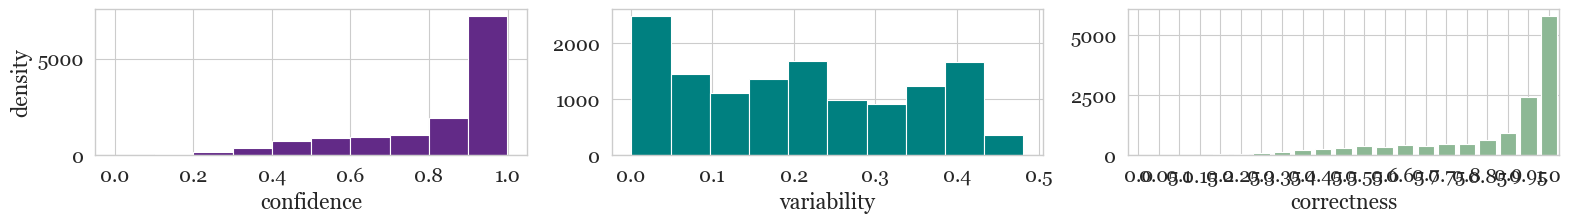

In [19]:

base_path ='vqa_models/vqa_lxr955_animals_fromScratch_20epochs/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
plot_histograms(df, title='VQA-Animals From Scratch - 20 epochs', show_hist=True)

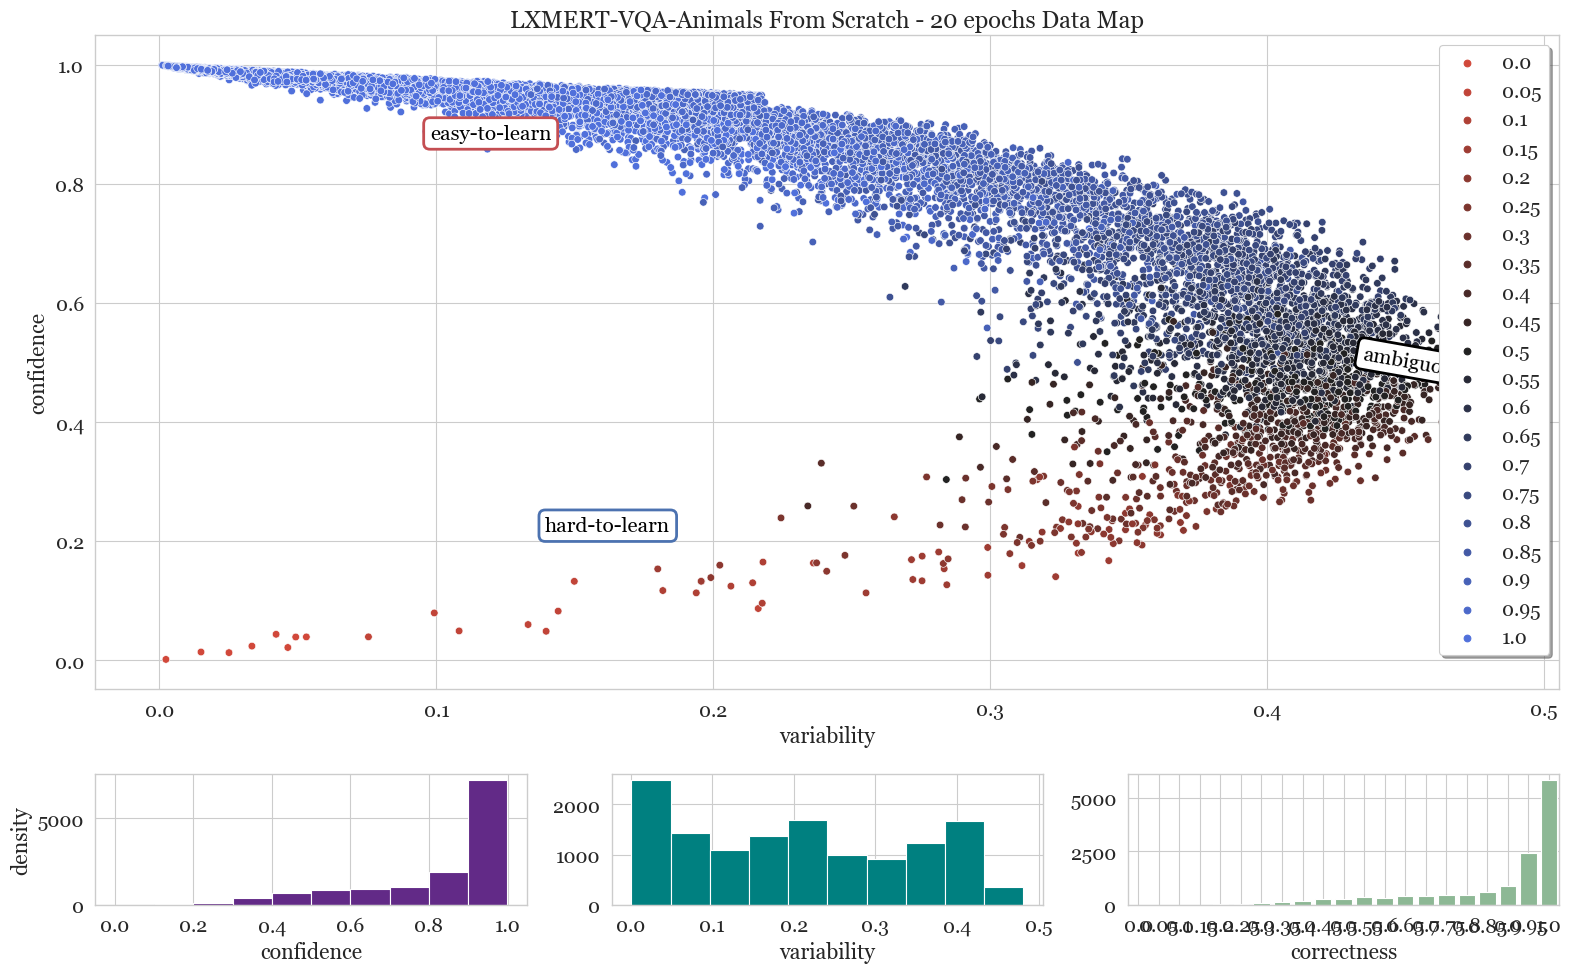

In [8]:

base_path ='vqa_models/vqa_lxr955_animals_fromScratch_20epochs/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")
scatter_it(df, title='VQA-Animals From Scratch - 20 epochs', show_hist=True)